
# Response Feature Sensitivity To Predictor Feature Nature Using K-nearest Neighbor

# Summary

This work flow aims to investigate how using two types of data (spatial and petrophysical) as predictor features can effect the predictions of porosity using challenges. K-nearest neighbor was used to as the method of interpretation, with both spacial (X &Y) and petrophysical (Permeability & AI) as predictor features, and porosity as response feature. Results show the model generated using spacial inputs had lower porosity estimations compared to the model that used petrophysical. Additionally, model generated using spacial inputs was smoother and used significantly higher K values. The findings of this show that there is a significant difference in porosity estimation that is dependent on the type of predictor.

# Objective & Justification

This objective of this workflow is to investigate k-nearest neighbor sensitivity to using spatial predictor features compared to petrophyiscal features.

# Justification: 
Porosity estimation was one of the biggest, as it can effect all of our models and simulations when drilling new wells. Predicting porosity in an unknown location given sparse porosity inputs is a strong tool that is not easily done. Given the ease of using k-nearest neighbor, if it can preform well while predicting porosity using spatial data then I can add that method to my toolkit. My hypothieses is that k-nearest neighbor will give close prediction of porosity given spatial data.

In [1]:
import os                                                   # to set current working directory 
import math                                                 # basic calculations like square root
import pandas as pd                                         # DataFrames and plotting
import numpy as np                                          # arrays and matrix math
import matplotlib.pyplot as plt                             # plotting

from sklearn.neighbors import KNeighborsRegressor           # for nearest k neighbours
from sklearn.model_selection import train_test_split        # train and test split
from sklearn.model_selection import cross_val_score         # cross validation methods

from sklearn import metrics                                 # measures to check our models
import pandas.plotting as pd_plot
from subprocess import check_call

from sklearn.preprocessing import StandardScaler
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper

# Functions

The following functions will be used in the work flow.

First Function, a function to visualize the ridge regression. this function takes  trained model, predictor and response features and plots the data and an exhaustive mesh of predictions so we can visualize  model

this function assumes 2 predictor features and 1 response feature

In [2]:
def visualize_model(model,xfeature,x_min,x_max,yfeature,y_min,y_max,response,z_min,z_max,title,):# plots the data points and the decision tree prediction 
    n_classes = 10
    cmap = plt.cm.RdYlBu
    plot_step = 0.02
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap,vmin=z_min, vmax=z_max, levels=np.linspace(z_min, z_max, 100))

    im = plt.scatter(xfeature,yfeature,s=None, c=response, marker=None, cmap=cmap, norm=None, vmin=z_min, vmax=z_max, alpha=0.8, linewidths=0.3,edgecolors="black")
    plt.title(title)
    plt.xlabel(xfeature.name)
    plt.ylabel(yfeature.name)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(response.name, rotation=270, labelpad=20)

Second & Third Functions here we have two functions. The two functions are grouped here for clarity, as we will be using them side-by-side in the work flow.

The 'accuracy_in_testing' is going to compare the error resulting from using inverse distance weighted approach vs. arithmetic average approach when using the K-nearest Neighbor method. The 'kFold_plot' function will show the error vs the K-nearest Neighbor number to determine our hyper parameter (K).

In [3]:
def accuracy_in_testing(Xtrn,Ytrn,Xtst,Ytst):    # plots the estimated vs. the actual 
    k = 1
    dist_error = []
    unif_error = []
    k_mat = np.linspace(1,50,50)
    while k <= 50:
        neigh_dist = KNeighborsRegressor(weights = 'distance', n_neighbors=k, p = 1)
        neigh_dist_fit = neigh_dist.fit(Xtrn,Ytrn)    # train the model with the training data
        y_pred = neigh_dist_fit.predict(Xtst)
        MSE = metrics.mean_squared_error(Ytst,y_pred)
        dist_error.append(MSE)
    
        neigh_unif = KNeighborsRegressor(weights = 'uniform', n_neighbors=k, p = 1)
        neigh_unif_fit = neigh_unif.fit(Xtrn,Ytrn)    # train the model with the training data
        y_pred = neigh_unif_fit.predict(Xtst)
        MSE = metrics.mean_squared_error(Ytst,y_pred)
        unif_error.append(MSE)
        k = k + 1
    plt.scatter(k_mat,dist_error,s=None, c='red',label = 'inverse distance weighted', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3,edgecolors="black")
    plt.scatter(k_mat,unif_error,s=None, c='blue',label = 'arithmetic average', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3,edgecolors="black")
    plt.title('Testing Error vs. K'); plt.xlabel('Number of Nearest Neighbours (K)'); plt.ylabel('Mean Square Error')
    plt.legend()
    
def kFold_plot(standered_predict_1,standered_predict_2,response_feature,method):    # plots the estimated vs. the actual    
    score = []                                                  # code modified from StackOverFlow by Dimosthenis
    k_mat = []
    for k in range(1,30):
        neigh_dist = KNeighborsRegressor(weights = method, n_neighbors=k, p = 1)
        scores = cross_val_score(estimator=neigh_dist, X= np.c_[standered_predict_1,standered_predict_2],y=response_feature, cv=2, n_jobs=4,scoring = "neg_mean_squared_error") # Perform 7-fold cross validation
        score.append(abs(scores.mean()))
        k_mat.append(k)

    plt.scatter(k_mat,score,s=None, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=0.5,edgecolors="black")
    plt.title('k-fold Error (MSE) vs. k Neighbours '+ '('+method+')'); plt.xlabel('Number of Nearest Neighbours'); plt.ylabel('Mean Squar')

Fourth Function a function plot the error in testing and training . This function takes predictor and response features and returns residual error.

In [4]:
def check_model(model,xfeature,yfeature,response,title,minmum,maximum):    # plots the estimated vs. the actual  
    predict_train = model.predict(np.c_[xfeature,yfeature])
    plt.scatter(response,predict_train,s=None, c='red',marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=0.3,edgecolors="black")
    plt.title(title); plt.xlabel('Actual VAlue'); plt.ylabel('Estimated VAlue')
    plt.xlim(minmum,maximum); plt.ylim(minmum,maximum)
    plt.arrow(minmum,minmum,maximum,maximum,width=0.02,color='black',head_length=0.0,head_width=0.0)
    MSE = metrics.mean_squared_error(response,predict_train)
    Var_Explained = metrics.explained_variance_score(response,predict_train)
    return(MSE,Var_Explained)

# Set the working directory

In [5]:
#os.chdir

We will also set a a random seed to keep our results consistent in each run

In [6]:
np.random.seed(752374)                                     # set the random number seed

# Set Working Directory & Load Data

The following work flow applies the .csv file 'spatial_nonlinear_MV_facies_v3.csv', a synthetic dataset by Dr. Michael Pyrcz. The dataset is publicly available 

We will work with the following features:

- X - The X-coordinate of the sample in ft
- Y - The Y-coordinate of the sample in ft
- porosity - fraction of rock void in units of percentage
- permeability - ability of a fluid to flow through the rock in mil;iDarcy
-acoustic impedence - product of sonic velocity and rock density in kg/m-sq-s

Importing the data:

In [7]:
df = pd.read_csv("spatial_nonlinear_MV_facies_v3.csv") 

# Basic Data Checking and Visualization

In [8]:
df.head()                                            # preview the first 5 rows of the dataframe

,Unnamed: 0,X,Y,Por,Perm,AI,Facies
0,458,150.0,909.0,13.133413,485.231659,3848.226472,1.0
1,228,690.0,9.0,3.235632,138.238177,5673.521586,0.0
2,324,825.0,775.0,9.012557,317.338989,4370.886936,1.0
3,252,530.0,759.0,11.138872,414.252249,4003.754472,1.0
4,318,775.0,75.0,9.233079,350.924567,4134.272337,1.0


Removing the well index and checking the summary summary statistics

In [9]:
df = df.iloc[:,1:7]
 #slice all rows and columns 1 through 6, note 0 and 7 column are removed
df.describe().transpose()                            # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
X,270.0,472.537037,288.917266,0.000000,225.000000,475.000000,745.000000,990.000000
Y,270.0,522.622222,277.643599,9.000000,309.000000,525.000000,769.000000,999.000000
Por,270.0,10.778590,3.665004,3.135247,7.909297,10.557808,13.119702,21.599413
Perm,270.0,406.286106,147.891654,138.238177,309.663433,408.150631,495.549617,798.263353
AI,270.0,4292.475630,433.786043,3630.239427,3981.691959,4192.107297,4491.224552,5701.203128
Facies,270.0,0.785185,0.411456,0.000000,1.000000,1.000000,1.000000,1.000000


Data Statistics looks good and there are no unreasonable values. Its a good idea to check the data before continuing on in case of any abnormalities.

We will use use once facies for our models to decrease the heterogeneity

In [10]:
df= df.loc[(df['Facies'] == 1 )  ] 


Lets visualize our data with a simple scatter plot

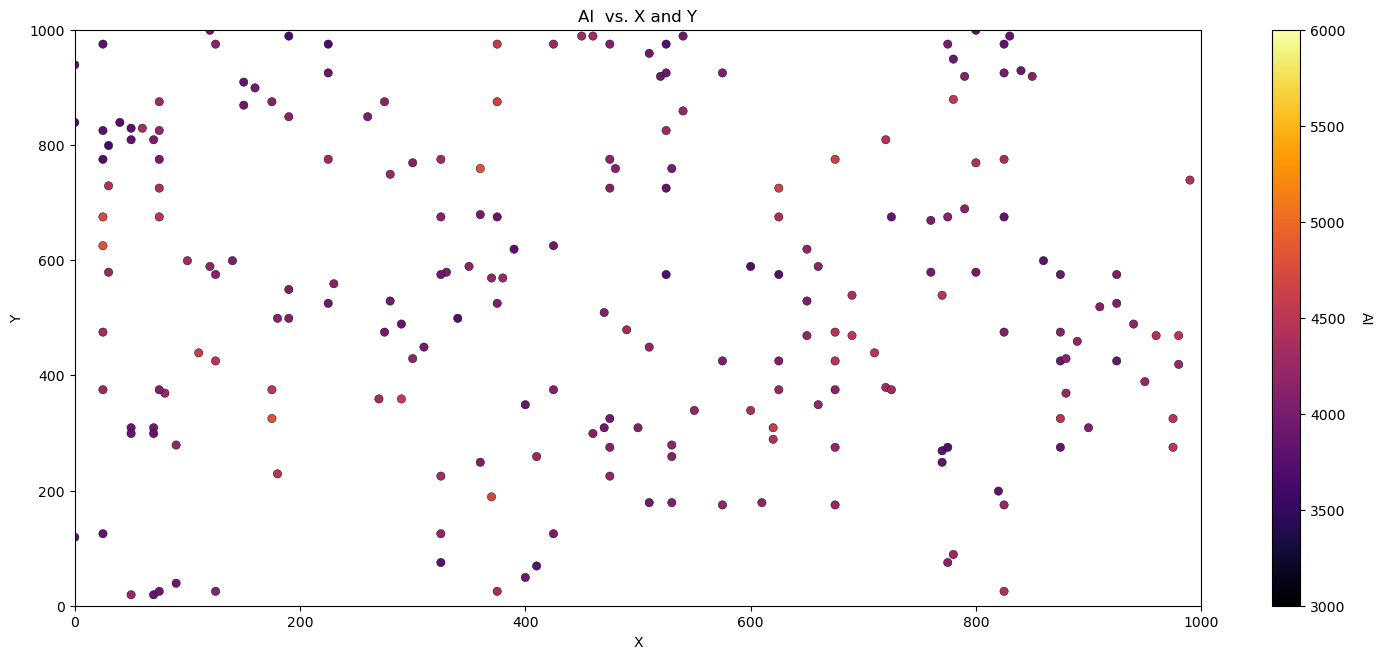

In [11]:
X_min = 0; X_max = 1000.0                         # predictor feature 1, X, range           
Y_min = 0; Y_max = 1000.0                         # predictor feature 2, Y, range
AI_min = 3000; AI_max = 6000                      # response feature range

cmap = plt.cm.inferno                                     # color map, variable tone and intensity for color blind individuals, and inferno is rad
im = plt.scatter(df["X"],df["Y"],s=None, c=df["AI"], marker=None, cmap=cmap, norm=None, vmin=AI_min, vmax=AI_max, alpha=1, linewidths=0.3, edgecolors="black")

plt.title('AI  vs. X and Y'); plt.xlabel('X'); plt.ylabel('Y')
cbar = plt.colorbar(im, orientation = 'vertical'); plt.xlim(X_min,X_max); plt.ylim(Y_min,Y_max)
cbar.set_label("AI", rotation=270, labelpad=20)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

Here we can see that AI varies significantly spatially.

In this workflow, we will deal with different variations of the data the we imported. Further visualization will be provided as we go in the workflow.

# Standardizing Predictor Features

The k-nearest neighbor method uses a nearest training sample search in feature space (like k-means clustering). To remove the impact feature range from the approach we standardize the features.

- we will standardize our predictor features to have a mean of zero and a variance of one.

- we use the scikikt learn preprocessing to simplify this step and provide a reverse transform.

In [12]:
transform = StandardScaler(); 

features = ['X','Y','Perm','AI']

df['sX'] = transform.fit_transform(df.loc[:,features].values)[:,0]    # standardize the data features to mean = 0, var = 1.0
df['sY'] = transform.fit_transform(df.loc[:,features].values)[:,1]    # standardize the data features to mean = 0, var = 1.0
df['sPerm'] = transform.fit_transform(df.loc[:,features].values)[:,2] # standardize the data features to mean = 0, var = 1.0
df['sAI'] = transform.fit_transform(df.loc[:,features].values)[:,3]   # standardize the data features to mean = 0, var = 1.0
df.describe().transpose() 

,count,mean,std,min,25%,50%,75%,max
X,212.0,4.611085e+02,292.201275,0.000000,190.000000,472.500000,720.000000,990.000000
Y,212.0,5.471415e+02,270.158666,19.000000,335.500000,534.000000,775.000000,999.000000
Por,212.0,1.191146e+01,3.243477,3.135247,9.703136,11.877467,13.948399,21.599413
Perm,212.0,4.634681e+02,110.557018,268.341560,387.850252,444.554224,526.905927,798.263353
AI,212.0,4.119199e+03,253.682313,3630.239427,3923.478665,4102.218838,4274.945679,4816.235233
Facies,212.0,1.000000e+00,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
sX,212.0,-1.256856e-17,1.002367,-1.581786,-0.930010,0.039077,0.888101,1.814309
sY,212.0,3.456355e-17,1.002367,-1.959558,-0.785251,-0.048759,0.845421,1.676526
sPerm,212.0,3.362090e-16,1.002367,-1.769118,-0.685590,-0.171483,0.575160,3.035426
sAI,212.0,5.865329e-16,1.002367,-1.932010,-0.773343,-0.067093,0.615397,2.754177


# Workflow Outline

The plan for this workflow is to predict porosity in a new location (spacial space or feature space) not in our data set, using two methods. Once using X and Y as predictor features and a second time using permeability and AI as predictor features.

In the first aforementioned case, its a straight forward workflow. I will simply do, apply our model normally, then find out the porosity values in the new location.

In the second case though, need to do additional steps. Since we want the porosity in a brand new location that is not given in our data set, we don't know the AI and permeability in that location.

- So  first must find the AI and Permeability of that location. Once we have that information, we will hold on to it until the next step.

- Then, build another model to predict porosity given AI and permeability.

- Next, we will simply use the AI and permeability that we generated in the new locations before as pseudo-locations in the multivariate feature space to find porosity.

Finally, we will compare the result of the two methods.

These are the steps we will use in this work flow:

- Build model of AI given X and Y
  - Find AI in new locations

- Build model of Permeability given X and Y
  - Find Permeability in new locations

- Build model of Porosity given AI and Permeability

- Build model of Porosity given X and Y

- Compare the two methods

Now, we will set our new locations variable that we will be using in the workflow.

In [23]:
Y_RanLocation = list(range(0,1000,10))    # make a vector of 1 100 X values from 0 to 1000 with 10-sized step
X_RanLocation = list(range(0,1000,10))    # make a vector of 1 100 X values from 0 to 1000 with 10-sized step


Random_Locations = np.zeros((len(Y_RanLocation)*len(X_RanLocation),2))

for i in  range(len(X_RanLocation)):   # compine X and Y in a 2X100 matrix such that every X value is compianed with each Y value 
        if i==0:
            for j in  range(len(X_RanLocation)):
                Random_Locations[j][0]= (X_RanLocation[i])
                Random_Locations[j][1]= (Y_RanLocation[j])
        else:
            for j in  range(len(X_RanLocation)):
                Random_Locations[i*len(X_RanLocation)+j][0]= (X_RanLocation[i])
                Random_Locations[i*len(X_RanLocation)+j][1]= (Y_RanLocation[j])
               
    
X_RanLocation,Y_RanLocation=zip(*Random_Locations) # Saparate X and Y back to use them later on

# Build model of AI given X and Y

In this step, we will use K-nearest neighbor to predict AI given X and Y positions

Lets start with declaring our variables

In [24]:
X = df[['sX','sY']]                         # slice predictor features, X and Y of all samples
y = df[['AI']]                               # slice repsonse features, AI all samples

Now, lets set our limits that we will be using later on in the workflow

In [25]:
X_min = -2; X_max = 2                        # predictor feature 1, X1, range           
Y_min = -2; Y_max = 2                         # predictor feature 2, X2, range
AI_min = 3000; AI_max = 5000                      # response feature range
#cmap = plt.cm.inferno                             # color map
#error_min = -5000.0; error_max = 5000.0           # prediction error range
#nbin = 40    # number of bins in histograms

In order to build our model, we need to split our data to testing and training.

We will use a testing size of 20% of our data. Note that there is no shuffling of the data in the function below, because we want our workflow to display consistent result in each run. It is easier to compare the data that way.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None,shuffle=False) # train and test split
n_train = len(X_train)
n_test = len(X_test)
print('Number of training ' + str(n_train) + ', number of test ' + str(n_test))

Number of training 169, number of test 43


Lets visualize what we have done so far with a scatter plot

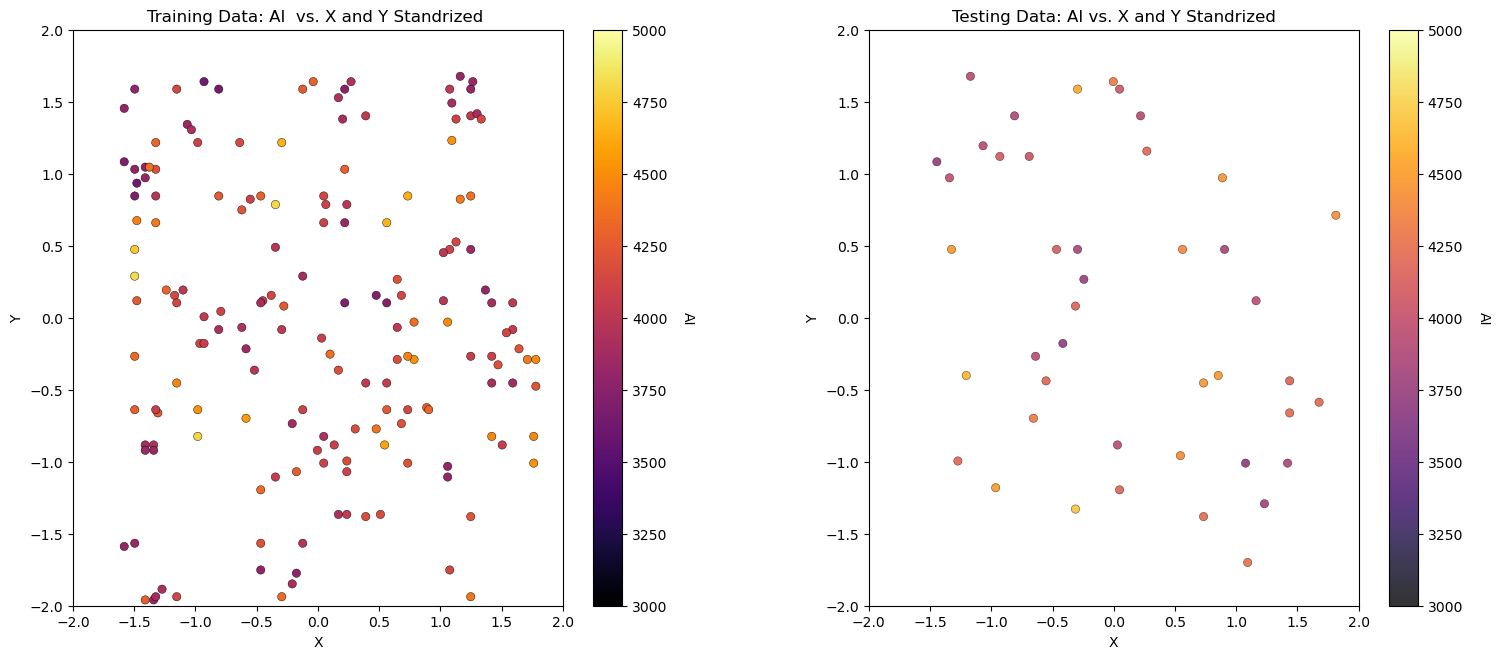

In [17]:
plt.subplot(121)                                          # scatter plot of the training data, 1 row x 2 columns
im = plt.scatter(X_train["sX"],X_train["sY"],s=None, c=y_train["AI"], marker=None, cmap=cmap, norm=None, vmin=AI_min, vmax=AI_max, alpha=1, linewidths=0.3, edgecolors="black")
plt.title('Training Data: AI  vs. X and Y Standrized '); plt.xlabel('X'); plt.ylabel('Y')
cbar = plt.colorbar(im, orientation = 'vertical'); plt.xlim(X_min,X_max); plt.ylim(Y_min,Y_max)
cbar.set_label("AI", rotation=270, labelpad=20)

plt.subplot(122)                                          # scatter plot of the testing data, 1 row x 2 columns
im = plt.scatter(X_test["sX"],X_test["sY"],s=None, c=y_test["AI"], marker=None, cmap=cmap, norm=None, vmin=AI_min, vmax=AI_max, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.title('Testing Data: AI vs. X and Y Standrized'); plt.xlabel('X'); plt.ylabel('Y')
cbar = plt.colorbar(im, orientation = 'vertical'); plt.xlim(X_min,X_max); plt.ylim(Y_min,Y_max)
cbar.set_label("AI", rotation=270, labelpad=20)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

Plots look good. We can clearly see that the testing data is a representable data sample of our data set.

Next, we will use our third function from the start of the workflow to determine the hyperparameter necessary for us to build our K-nearest Neighbor model

 # Hyperparameters Tuning

Next, we will use our second and third functions from the start of the workflow to determine the hyperparameter necessary for us to build our K-nearest Neighbor model

Here will preform the following

- Compare arithmetic averaging and inverse distance weighing to find which has the lowest testing error (Accuracy).
- Preform k-fold cross validation to see at which K value we will have the smallest error.

These two graphs will allow us to tune our model with the best method and the best K for minimizing the test error.

The testing error is our focus here because thats how we evaluate our model. Constructing the model otherwise (minimizing training error) would result in a model that test's poorly, and thats is not our goal.

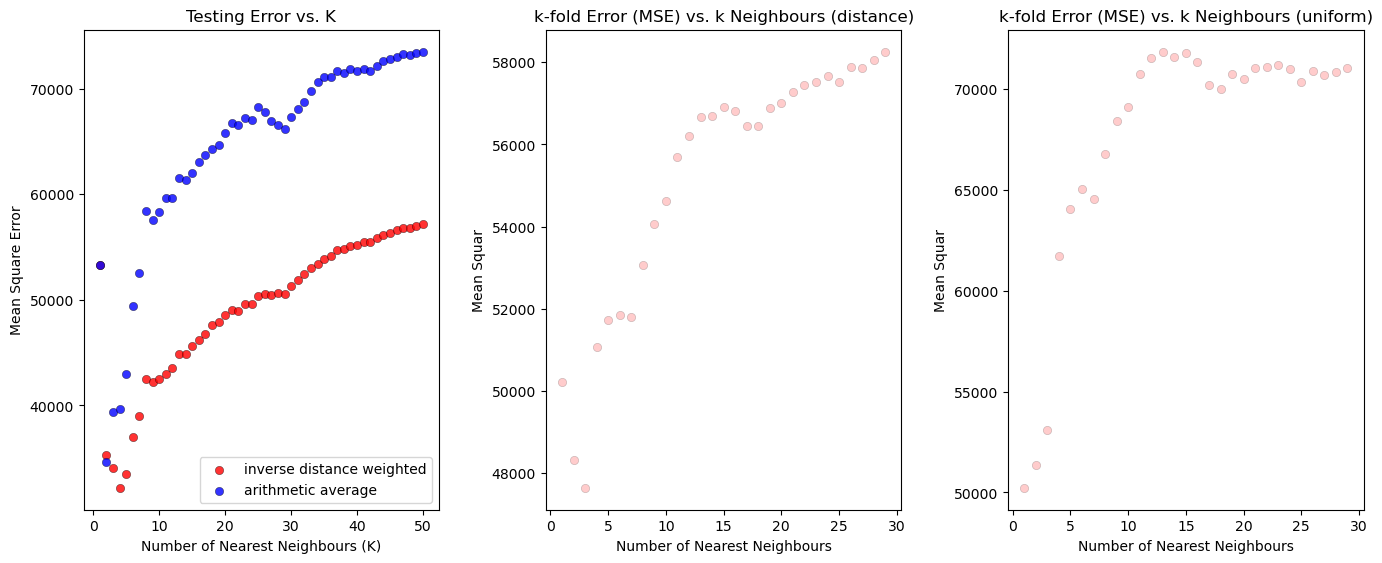

In [18]:
plt.subplot(131)
accuracy_in_testing(X_train,y_train['AI'],X_test,y_test['AI'])

plt.subplot(132)
kFold_plot(df['sX'],df['sY'],df['AI'],'distance')

plt.subplot(133)
kFold_plot(df['sX'],df['sY'],df['AI'],'uniform')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1, wspace=0.3, hspace=0.2)
plt.show()

From our first plot (Left), we can quickly notice that arithmetic averaging has a higher testing error compared to inverse distance weighing. This makes us easier for us to pick which parameter to use, as our goal is to minimize testing error, and inverse distance weighing is the winner!

From the second plot (Middle), we can see the testing error at each number of K neighbors. A very clear minimum at *k* = 3 suggest that this is the optimal K value to use for our model.

With our hyperparameters tuned and ready, we can now Build Our Model. We will show both the training and testing model plots.

/Users/dbc/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/dbc/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


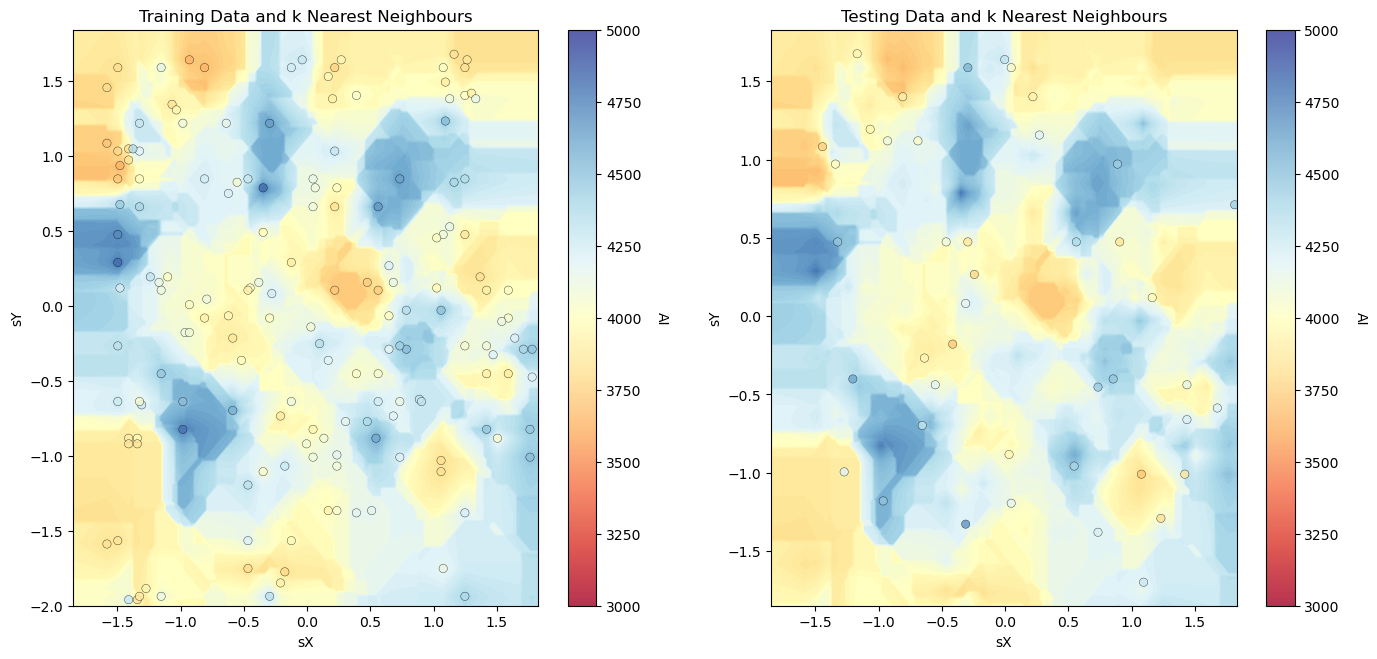

In [19]:
neigh = KNeighborsRegressor(weights = 'distance', n_neighbors=3, p = 1) # instantiate the prediction model
neigh_fit = neigh.fit(X_train,y_train['AI'])              # train the model with the training data

plt.subplot(121)
visualize_model(neigh_fit,X_train["sX"],-1.85,1.85,X_train["sY"],-2,1.85,y_train["AI"],AI_min,AI_max,'Training Data and k Nearest Neighbours')

plt.subplot(122)
visualize_model(neigh_fit,X_test["sX"],-1.85,1.85,X_test["sY"],-1.85,1.85,y_test["AI"],AI_min,AI_max,'Testing Data and k Nearest Neighbours')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

The model looks good. We can see the heterogeneities across our model reservoir with patches of high and low AI.

Additionally, through ocular inspection, we can see that our testing data falls relatively close on the model to where they should be. Meaning that there AI value that is 5000 and falling in a 3000 AI region.

However, we will not stop at ocular inspection, as our next step would be to use error metrics to examine our model performance much more closely.

# Cross Validation

We will move with the workflow to use our Third function to cross validate our model.

Here we will be able to see how our model preformed both in testing and in training.

/Users/dbc/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/dbc/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/dbc/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/dbc/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


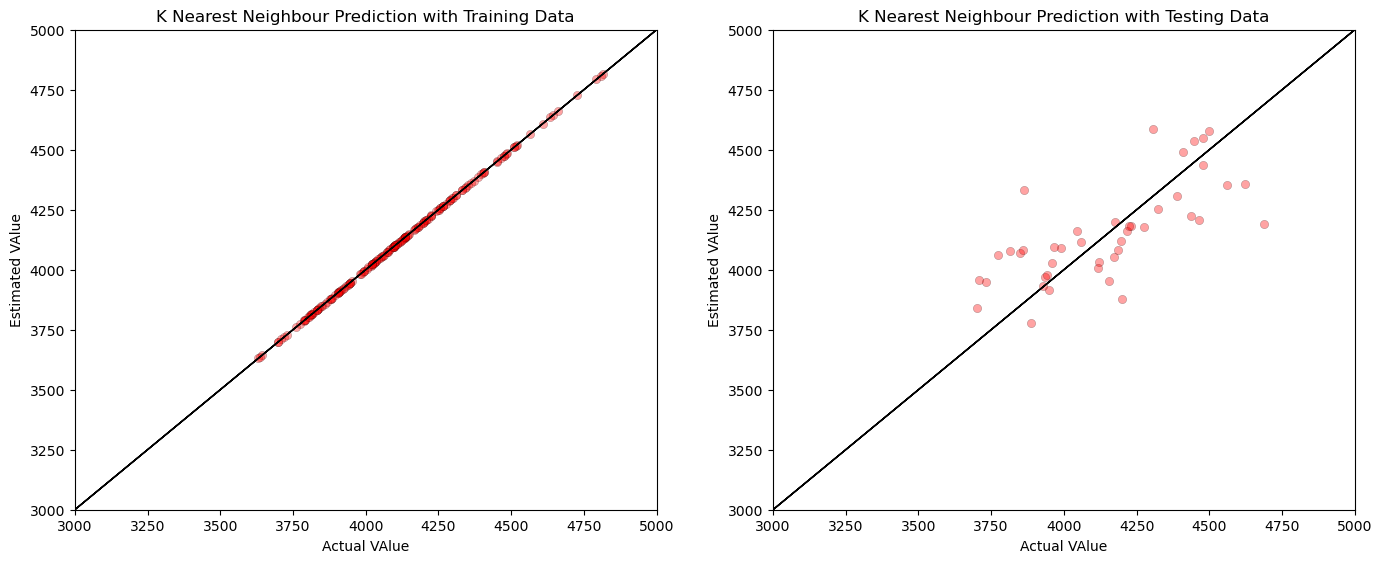

Mean Squared Error in Training =  0.0 , Variance Explained = 1.0
Mean Squared Error in Testing =  34090.25 , Variance Explained = 0.5


In [20]:
neigh = KNeighborsRegressor(weights = 'distance', n_neighbors=3, p = 1) # instantiate the prediction model

neigh_fit = neigh.fit(X_train,y_train['AI'])              # train the model with the training data


plt.subplot(121)
check_model(neigh_fit,X_train["sX"],X_train["sY"],y_train["AI"],'K Nearest Neighbour Prediction with Training Data',AI_min,AI_max)
MSE1,Var1 = check_model(neigh_fit,X_train["sX"],X_train["sY"],y_train["AI"],'K Nearest Neighbour Prediction with Training Data',AI_min,AI_max)

plt.subplot(122)
check_model(neigh_fit,X_test["sX"],X_test["sY"],y_test["AI"],'K Nearest Neighbour Prediction with Testing Data',AI_min,AI_max)
MSE2,Var2 =check_model(neigh_fit,X_test["sX"],X_test["sY"],y_test["AI"],'K Nearest Neighbour Prediction with Testing Data',AI_min,AI_max)


plt.subplots_adjust(left=0.0, bottom=0, right=2, top=1, wspace=.2, hspace=0.2)
plt.show()

print('Mean Squared Error in Training = ', round(MSE1,2),', Variance Explained =', round(Var1,2))
print('Mean Squared Error in Testing = ', round(MSE2,2),', Variance Explained =', round(Var2,2))

Here we can see that the training data is clearly matching very well. Usually, this is an indication of overfit since training is fitting better than testing data. However, remember that in a previous step we determined that inverse distance weighing preforms better in testing than arithmetic mean, despite the apparent over fit observed here. We will keep these hyper parameters as they better serve our purpose.

Finally, Lets now get the the AI values of our new location that we established at the start of this workflow

In [21]:
xx = GSLIB.affine(X_RanLocation,tmean = 1.0,tstdev = 1.0)  
yy= GSLIB.affine(Y_RanLocation,tmean = 1.0,tstdev = 1.0)  
AI_predicted = neigh_fit.predict(np.c_[xx, yy])

/Users/dbc/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


The output here are the AI values of the new locations.

# Build model of Perm given X and Y

In this step, we will use K-nearest neighbor to predict Perm given X and Y positions. This step will be very similar to the previous step, so lets speed though it.

In [37]:
X = df[['sX','sY']]                            # slice predictor features, sX and sY of all samples
y = df[['Perm']]                               # slice repsonse features, AI for all samples


Now, lets set our limits that we will be using later on in the workflow

In [29]:
Perm_min = 100; Perm_max = 800                        # response feature range

sX and sY values are the same as in the previous step

Just like last step, we will do a a testing- training split, but this time with Permeability as a response feature with a testing size of 20% of our data.

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None,shuffle=False) # train and test split
n_train = len(X_train)
n_test = len(X_test)
print('Number of training ' + str(n_train) + ', number of test ' + str(n_test))

Number of training 169, number of test 43


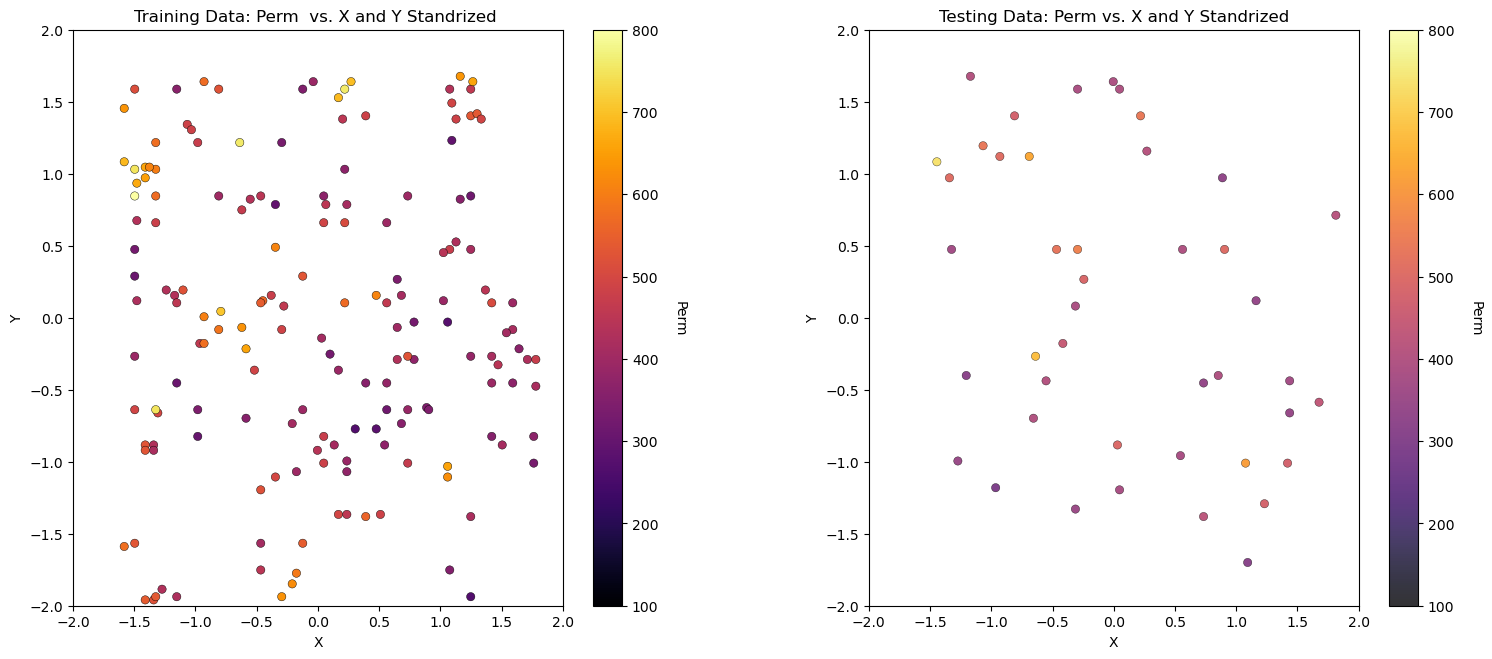

In [39]:
plt.subplot(121)                                          # scatter plot of the training data, 1 row x 2 columns
im = plt.scatter(X_train["sX"],X_train["sY"],s=None, c= y_train["Perm"], marker=None, cmap=cmap, norm=None, vmin=Perm_min, vmax=Perm_max, alpha=1, linewidths=0.3,edgecolors="black")
plt.title('Training Data: Perm  vs. X and Y Standrized '); plt.xlabel('X'); plt.ylabel('Y')
cbar = plt.colorbar(im, orientation = 'vertical'); plt.xlim(X_min,X_max); plt.ylim(Y_min,Y_max)
cbar.set_label("Perm", rotation=270, labelpad=20)

plt.subplot(122)                                          # scatter plot of the testing data, 1 row x 2 columns
im = plt.scatter(X_test["sX"],X_test["sY"],s=None, c=y_test["Perm"], marker=None, cmap=cmap, norm=None, vmin=Perm_min, vmax=Perm_max, alpha=0.8, linewidths=0.3,edgecolors="black")
plt.title('Testing Data: Perm vs. X and Y Standrized'); plt.xlabel('X'); plt.ylabel('Y')
cbar = plt.colorbar(im, orientation = 'vertical'); plt.xlim(X_min,X_max); plt.ylim(Y_min,Y_max)
cbar.set_label("Perm", rotation=270, labelpad=20)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

# Hyperparameters Tuning

Next, we will use our second function from the start of the workflow to determine the hyperparameter necessary for us to build our K-nearest Neighbor model

Here will preform the following:

- Compare arithmetic averaging and inverse distance weighing to find which has the lowest testing error (Accuracy).
- Preform k-fold cross validation to see at which K value we will have the smallest error.

These two graphs will allow us to tune our model with the best method and the best K for minimizing the test error.

The testing error is our focus here because thats how we evaluate our model. Constructing the model otherwise (minimizing training error) would result in a model that test's poorly, and thats is not our goal.

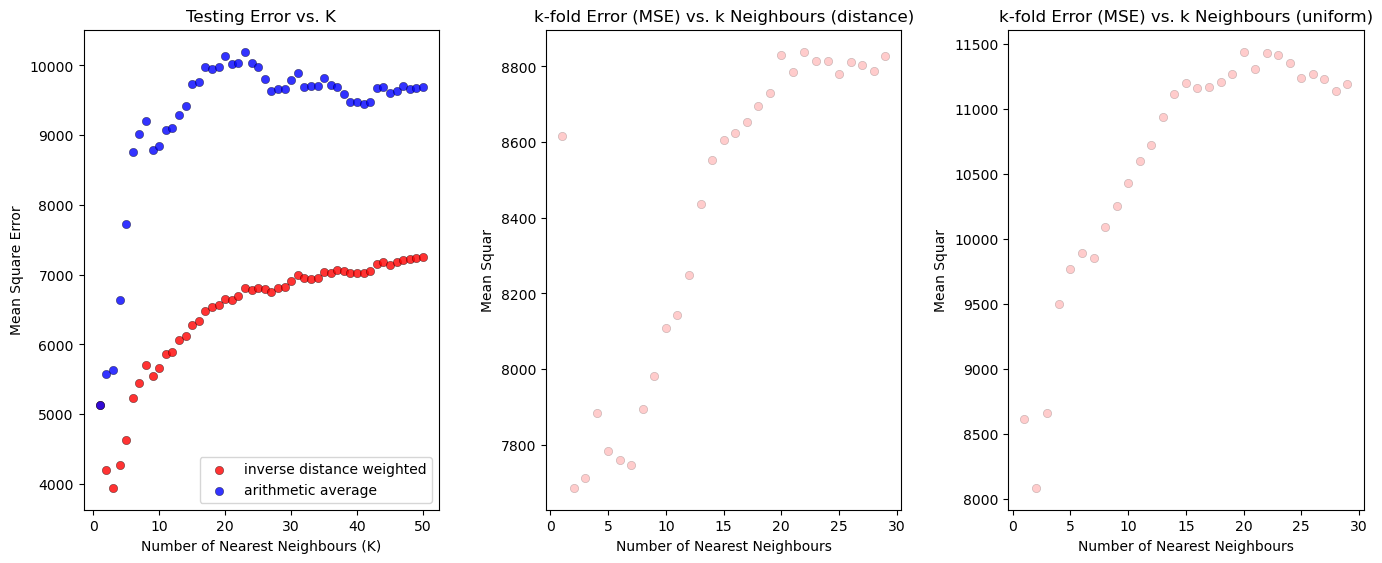

In [41]:
plt.subplot(131)
accuracy_in_testing(X_train,y_train['Perm'],X_test,y_test['Perm'])

plt.subplot(132)
kFold_plot(df['sX'],df['sY'],df['Perm'],'distance')

plt.subplot(133)
kFold_plot(df['sX'],df['sY'],df['Perm'],'uniform')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1, wspace=0.3, hspace=0.2)
plt.show()

Just like last step, we see that arithmetic averaging has a higher testing error compared to inverse distance weighing. Hence, inverse distance weighing is our pick to minimize testing error

From the second plot (Middle), we can see the testing error at each number of K neighbors. A very clear minimum at *k* = 2 suggest that this is the optimal K value to use for our model.

With our hyperparameters tuned and ready, we can now Build Our Model. We will show both the training and testing model plots.

/Users/dbc/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/dbc/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


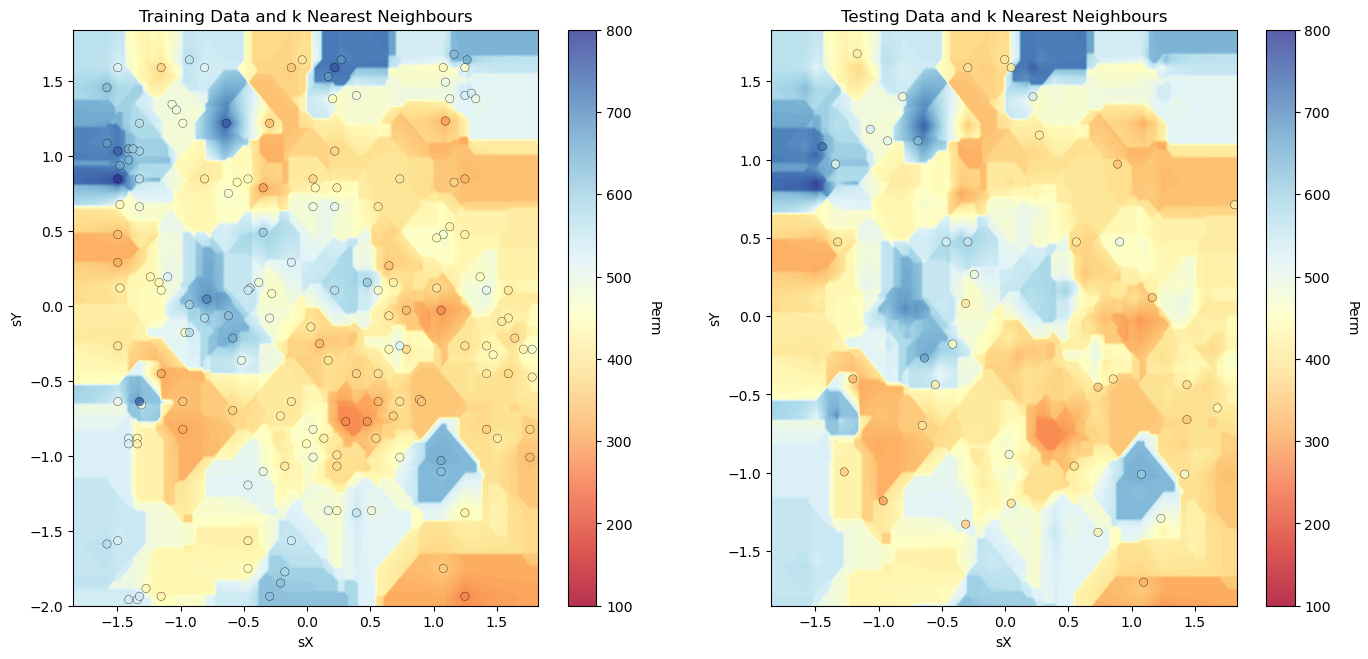

In [43]:
neigh = KNeighborsRegressor(weights = 'distance', n_neighbors=2, p = 1) # instantiate the prediction model
neigh_fit = neigh.fit(X_train,y_train['Perm'])              # train the model with the training data

plt.subplot(121)
visualize_model(neigh_fit,X_train["sX"],-1.85,1.85,X_train["sY"],-2,1.85,y_train["Perm"],Perm_min,Perm_max,'Training Data and k Nearest Neighbours')

plt.subplot(122)
visualize_model(neigh_fit,X_test["sX"],-1.85,1.85,X_test["sY"],-1.85,1.85,y_test["Perm"],Perm_min,Perm_max,'Testing Data and k Nearest Neighbours')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

The model looks good. We can see the heterogeneities across our model reservoir with patches of high and low Permeability, which makes sense.

testing points look good too, as they are generally where they should be with acceptable variations compared to model predictions.

Our next step would be to use error metrics to examine our model performance.

# Cross Validation

We will move with the workflow to use our Third function to cross validate our model.

Here we will be able to see how our model preformed both in testing and in training.

/Users/dbc/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/dbc/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/dbc/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/dbc/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


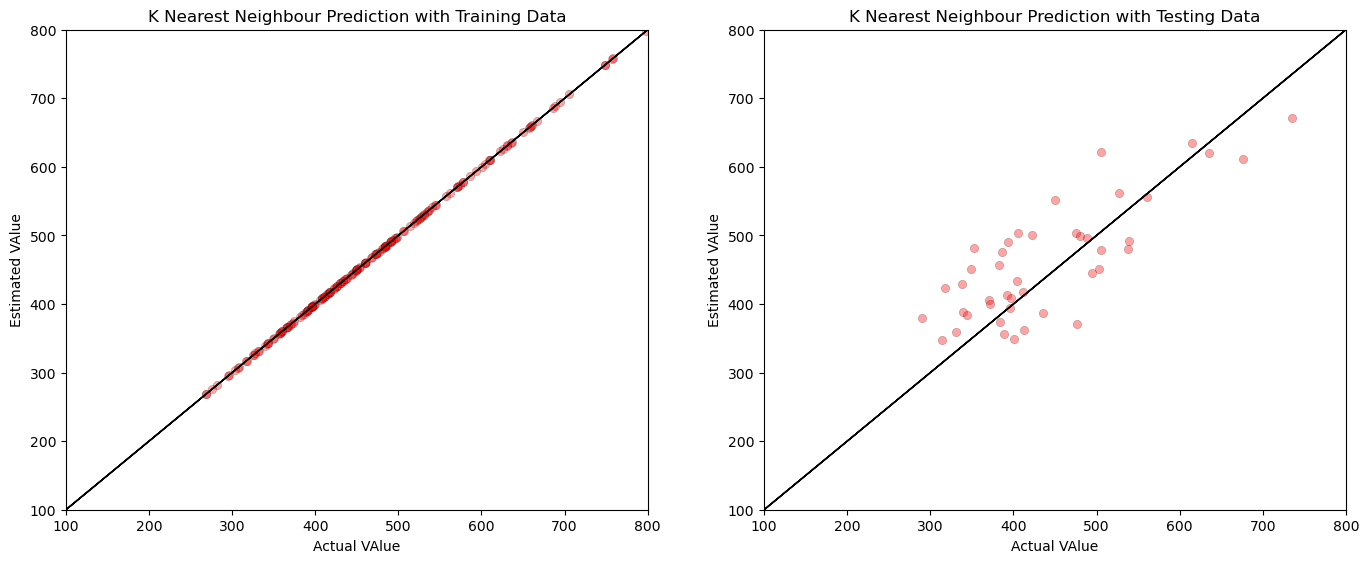

Mean Squared Error in Training =  0.0 , Variance Explained = 1.0
Mean Squared Error in Testing =  3943.22 , Variance Explained = 0.64


In [44]:
neigh = KNeighborsRegressor(weights = 'distance', n_neighbors=3, p = 1) # instantiate the prediction model

neigh_fit = neigh.fit(X_train,y_train['Perm'])              # train the model with the training data


plt.subplot(121)
check_model(neigh_fit,X_train["sX"],X_train["sY"],y_train["Perm"],'K Nearest Neighbour Prediction with Training Data',Perm_min,Perm_max)
MSE1,Var1 = check_model(neigh_fit,X_train["sX"],X_train["sY"],y_train["Perm"],'K Nearest Neighbour Prediction with Training Data',Perm_min,Perm_max)

plt.subplot(122)
check_model(neigh_fit,X_test["sX"],X_test["sY"],y_test["Perm"],'K Nearest Neighbour Prediction with Testing Data',Perm_min,Perm_max)
MSE2,Var2 =check_model(neigh_fit,X_test["sX"],X_test["sY"],y_test["Perm"],'K Nearest Neighbour Prediction with Testing Data',Perm_min,Perm_max)


plt.subplots_adjust(left=0.0, bottom=0, right=2, top=1, wspace=.2, hspace=0.2)
plt.show()

print('Mean Squared Error in Training = ', round(MSE1,2),', Variance Explained =', round(Var1,2))
print('Mean Squared Error in Testing = ', round(MSE2,2),', Variance Explained =', round(Var2,2))

Here we can see that the training data is clearly matching very well. Usually, this is an indication of overfit since traininig is fitting better than testing data. However, remember that in a previous step we determined that inverse distance weighing preforms better in testing than arithmetic mean, despite the apparent over fit observed here. We will keep these hyper parameters as they better serve our purpose.

Finally, Lets now get the the AI values of our new location that we established at the start of this workflow

In [45]:
xx = GSLIB.affine(X_RanLocation,tmean = 1.0,tstdev = 1.0)  
yy= GSLIB.affine(Y_RanLocation,tmean = 1.0,tstdev = 1.0)  
Perm_predicted = neigh_fit.predict(np.c_[xx, yy])
Perm_predicted

/Users/dbc/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


array([342.0604828 , 342.67159923, 341.60144957, ..., 585.72075513,
       585.71108914, 585.7016857 ])

 # Build model of Porosity given AI and Permeability

In this step, we will use K-nearest Neighbor predict Porosity given AI and Permeability positions

Lets start with declaring our variables

In [47]:
X = df[['sPerm','sAI']]                       # slice predictor features, porosity and brittleness all samples
y = df[['Por']]                               # slice repsonse features, production all samples

Now, lets set our limits that we will be using later on in the workflow

In [48]:
perm_min = -2; perm_max = 3.05                            # predictor feature 1, X1, range           
AI_min = -2; AI_max = 3                   # predictor feature 2, X2, range
por_min = 0.0; por_max = 25                        # response feature range

In order to build our model, we need to split our data to testing and training.

We will use a testing size of 20% of our data. Note that there is no shuffling of the data in the function below, because we want our workflow to display consistent result in each run. It is easier to compare the data that way.

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None,shuffle=False) # train and test split
n_train = len(X_train)
n_test = len(X_test)
print('Number of training ' + str(n_train) + ', number of test ' + str(n_test))

Number of training 169, number of test 43


Lets visualize what we have done so far with a scatter plot

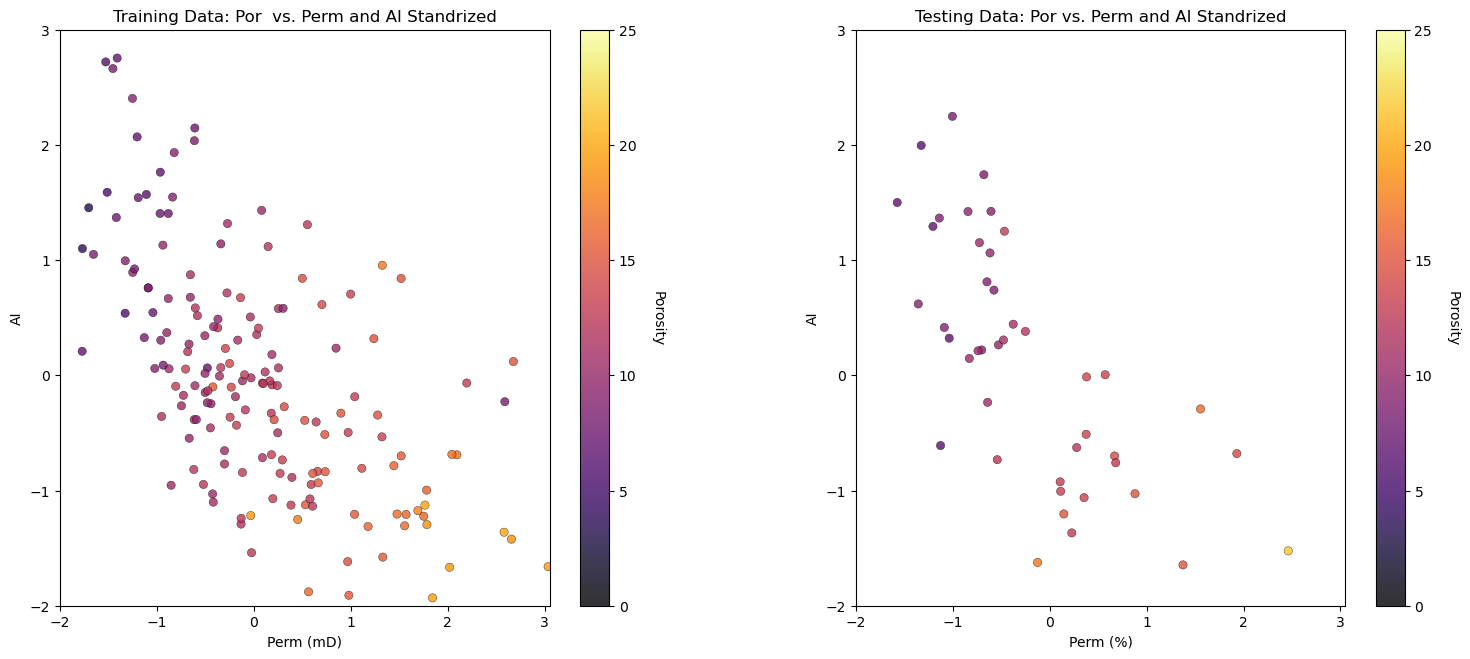

In [51]:
plt.subplot(121)                                          # scatter plot of the training data, 1 row x 2 columns
im = plt.scatter(X_train["sPerm"],X_train["sAI"],s=None, c=y_train["Por"], marker=None, cmap=cmap, norm=None, vmin=por_min, vmax=por_max, alpha=0.8, linewidths=0.3,edgecolors="black")
plt.title('Training Data: Por  vs. Perm and AI Standrized'); plt.xlabel('Perm (mD)'); plt.ylabel('AI')
cbar = plt.colorbar(im, orientation = 'vertical'); plt.xlim(perm_min,perm_max); plt.ylim(AI_min,AI_max)
cbar.set_label("Porosity", rotation=270, labelpad=20)

plt.subplot(122)                                          # scatter plot of the testing data, 1 row x 2 columns
im = plt.scatter(X_test["sPerm"],X_test["sAI"],s=None, c=y_test["Por"], marker=None, cmap=cmap, norm=None, vmin=por_min, vmax=por_max, alpha=0.8, linewidths=0.3,edgecolors="black")
plt.title('Testing Data: Por vs. Perm and AI Standrized'); plt.xlabel('Perm (%)'); plt.ylabel('AI')
cbar = plt.colorbar(im, orientation = 'vertical'); plt.xlim(perm_min,perm_max); plt.ylim(AI_min,AI_max)
cbar.set_label("Porosity", rotation=270, labelpad=20)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

Plots look good. We can clearly see that the testing data is a representable data sample of our data set.

# Hyperparameters Tuning

Next, we will use our fourth function from the start of the workflow to determine the hyperparameter necessary for us to build our K-nearest Neighbor model

Here will preform the following:

- Compare arithmetic averaging and inverse distance weighing to find which has the lowest testing error (Accuracy).
- Preform k-fold cross validation to see at which K value we will have the smallest error.

These two graphs will allow us to tune our model with the best method and the best K for minimizing the test error.

The testing error is our focus here because thats how we evaluate our model. Constructing the model otherwise (minimizing training error) would result in a model that test's poorly, and thats is not our goal.

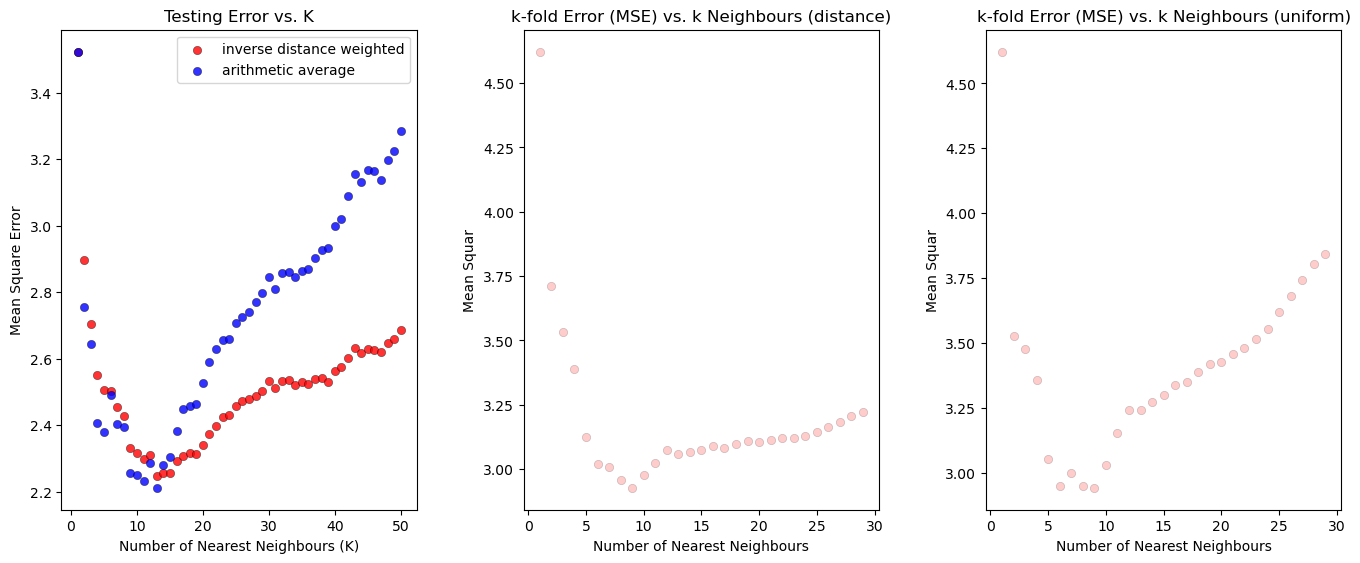

In [52]:
plt.subplot(131)
accuracy_in_testing(X_train,y_train['Por'],X_test,y_test['Por'])

plt.subplot(132)
kFold_plot(df['sPerm'],df['sAI'],df['Por'],'distance')

plt.subplot(133)
kFold_plot(df['sPerm'],df['sAI'],df['Por'],'uniform')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1, wspace=0.3, hspace=0.2)
plt.show()

From our first plot (Left), we can see a different behavior compared to previous step s in the work flow. At low K values, arithmetic average preforms better, while the reverse happens at high K values.

This makes our pick for what weight function to use dependent on the next two plots. From the middle and right most plots of k-fold error vs K values, we see that in both cases we are dealing with low K-values as a our tuned hyperparameter, which is *k* = 9 in both cases. Hence, our pick will be the arithmetic average method for this step with *k* = 9.

With our hyperparameters tuned and ready, we can now Build Our Next Model. We will show both the training and testing model plots.

/Users/dbc/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/dbc/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


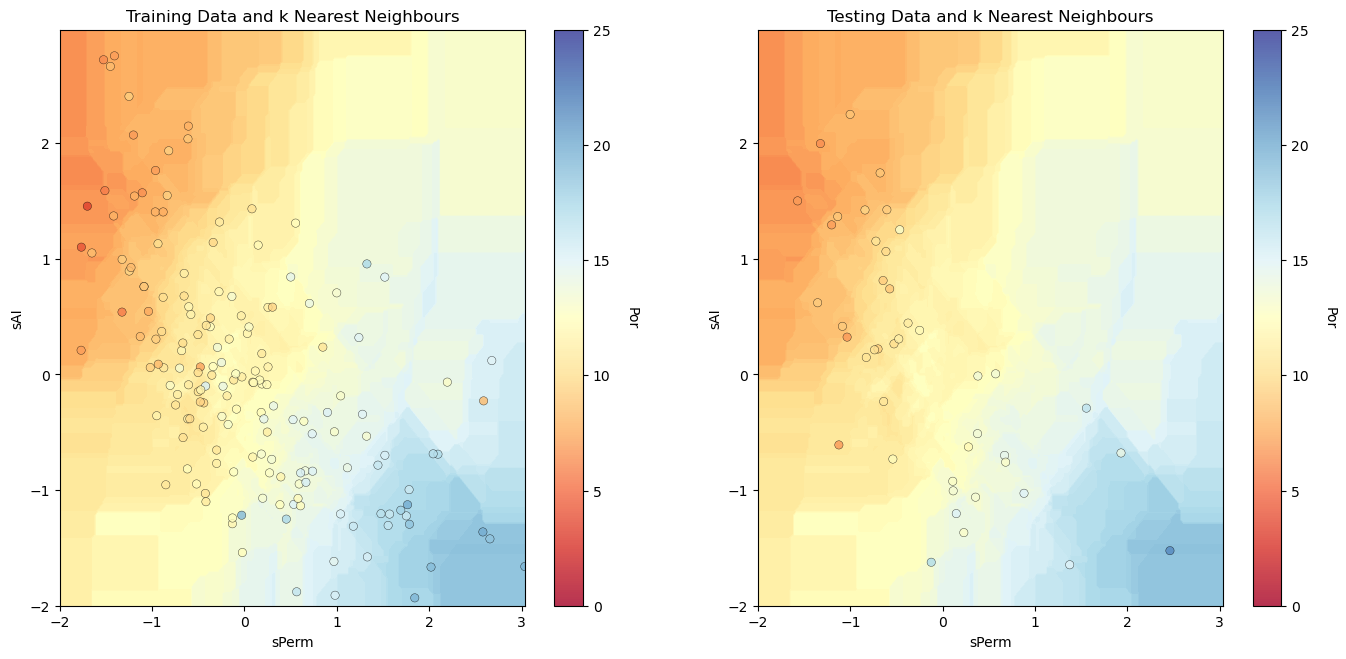

In [53]:
neigh = KNeighborsRegressor(weights = 'uniform', n_neighbors=9, p = 1) # instantiate the prediction model
neigh_fit = neigh.fit(X_train,y_train['Por'])              # train the model with the training data

plt.subplot(121)
visualize_model(neigh_fit,X_train["sPerm"],-2,3.05,X_train["sAI"],-2,3,y_train["Por"],por_min,por_max,'Training Data and k Nearest Neighbours')

plt.subplot(122)
visualize_model(neigh_fit,X_test["sPerm"],-2,3.05,X_test["sAI"],-2,3,y_test["Por"],por_min,por_max,'Testing Data and k Nearest Neighbours')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

We can quickly notice something different about our model here. There are regions at the top right and the bottom left that seems to be constant.

It seems that in these regions, the model doesnt have enough data to work with and just generalizes its interpretation based on the closest values it can find. This is understandable given that most of the data is distributed in a manner similar to a negative slope that is more dense towards the center than t the edges.

This behavior demonstrates a big limitation of the k-nearest neighbor method. The method needs data to make interpretations. This is a good representation of the concept of Lazy Learning.

Lazy Learning is a term to describe a model that doesn't learn a discriminative function from the training data, but rather uses the training data as part of its model along with the tuned hyper parameters. k-nearest neighbor is an instance based, lazy learning model that “memorize's” the training dataset instead of making a function of its own that is independent of the training data.

Now, other than the regions that we discussed, the model looks good and makes predictions that the testing data can agree with.

# Cross Validation

We will move with the workflow to use our Third function to cross validate our model.

Here we will be able to see how our model preformed both in testing and in training.

/Users/dbc/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/dbc/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/dbc/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/dbc/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


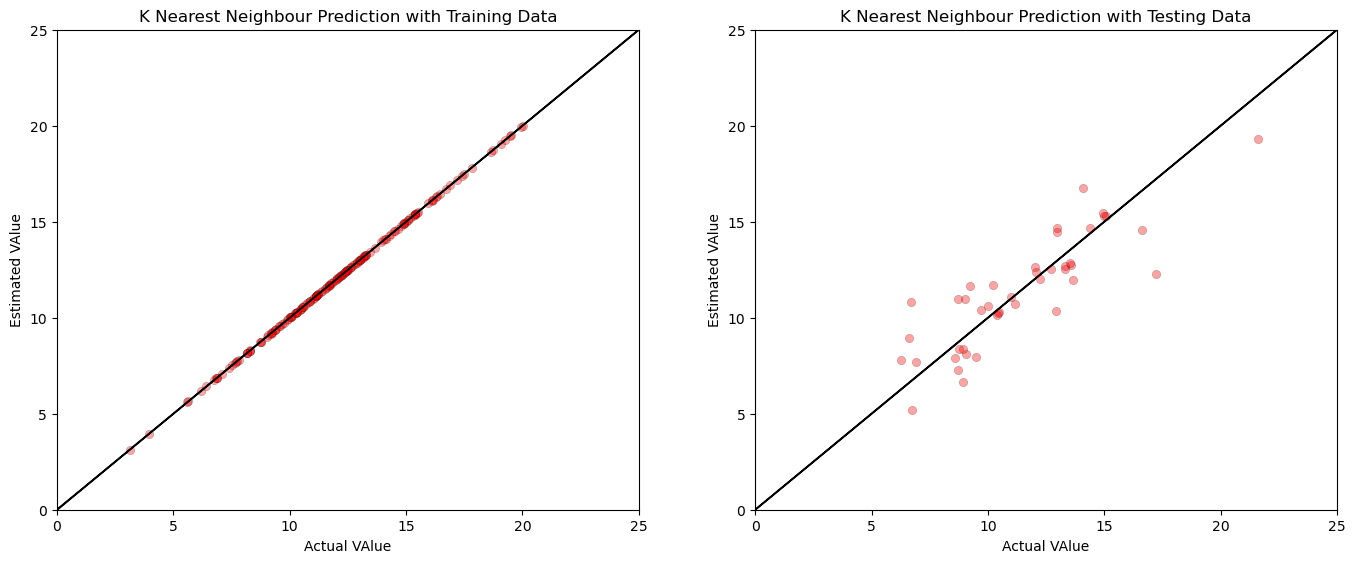

Mean Squared Error in Training =  0.0 , Variance Explained = 1.0
Mean Squared Error in Testing =  2.7 , Variance Explained = 0.73


In [54]:
neigh = KNeighborsRegressor(weights = 'distance', n_neighbors=3, p = 1) # instantiate the prediction model

neigh_fit = neigh.fit(X_train,y_train['Por'])              # train the model with the training data


plt.subplot(121)
check_model(neigh_fit,X_train["sPerm"],X_train["sAI"],y_train["Por"],'K Nearest Neighbour Prediction with Training Data',por_min,por_max)
MSE1,Var1 = check_model(neigh_fit,X_train["sPerm"],X_train["sAI"],y_train["Por"],'K Nearest Neighbour Prediction with Training Data',por_min,por_max)

plt.subplot(122)
check_model(neigh_fit,X_test["sPerm"],X_test["sAI"],y_test["Por"],'K Nearest Neighbour Prediction with Testing Data',por_min,por_max)
MSE2,Var2 =check_model(neigh_fit,X_test["sPerm"],X_test["sAI"],y_test["Por"],'K Nearest Neighbour Prediction with Testing Data',por_min,por_max)


plt.subplots_adjust(left=0.0, bottom=0, right=2, top=1, wspace=.2, hspace=0.2)
plt.show()

print('Mean Squared Error in Training = ', round(MSE1,2),', Variance Explained =', round(Var1,2))
print('Mean Squared Error in Testing = ', round(MSE2,2),', Variance Explained =', round(Var2,2))

Here we can see that the training data is clearly matching very well. Usually, this is an indication of overfit since traininig is fitting better than testing data. However, remember that in a previous step we determined that inverse distance weighing preforms better in testing than arithmetic mean, despite the apparent over fit observed here. We will keep these hyper parameters as they better serve our purpose.

With this step completed, we are ready to get our first porosity prediction of our new location that we established at the start of this workflow

In [55]:
xx = GSLIB.affine(Perm_predicted,tmean = 1.0,tstdev = 1.0)  
yy= GSLIB.affine(AI_predicted,tmean = 1.0,tstdev = 1.0)  
Porosity_Predicted_Petro = neigh_fit.predict(np.c_[xx, yy])
Porosity_Predicted_Petro

/Users/dbc/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


array([ 7.80851908,  7.80867559,  7.80886115, ..., 12.64881715,
       12.64919956, 12.64957184])

The output here are the Porosity values of the new locations using Permeability and AI as our predictor features. This will one of two porosity values vectors that we will compare at the final step of our workflow.

# Build model of Porosity given X and Y

In this workflow, we will use K-nearest Neighbor to predict Porosity given X and Y positions

Lets start with declaring our variables

In [56]:
X = df[['sX','sY']]                          # slice predictor features, sX and sY of all samples
y = df[['Por']]                               # slice repsonse features, production all samples

We will do our test-train split in the same way as before, but with X and Y as predictor features and Porosity as a response feature.

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None,shuffle=False) # train and test split
n_train = len(X_train)
n_test = len(X_test)
print('Number of training ' + str(n_train) + ', number of test ' + str(n_test))

Number of training 169, number of test 43


Lets visualize what we have done so far with a scatter plot

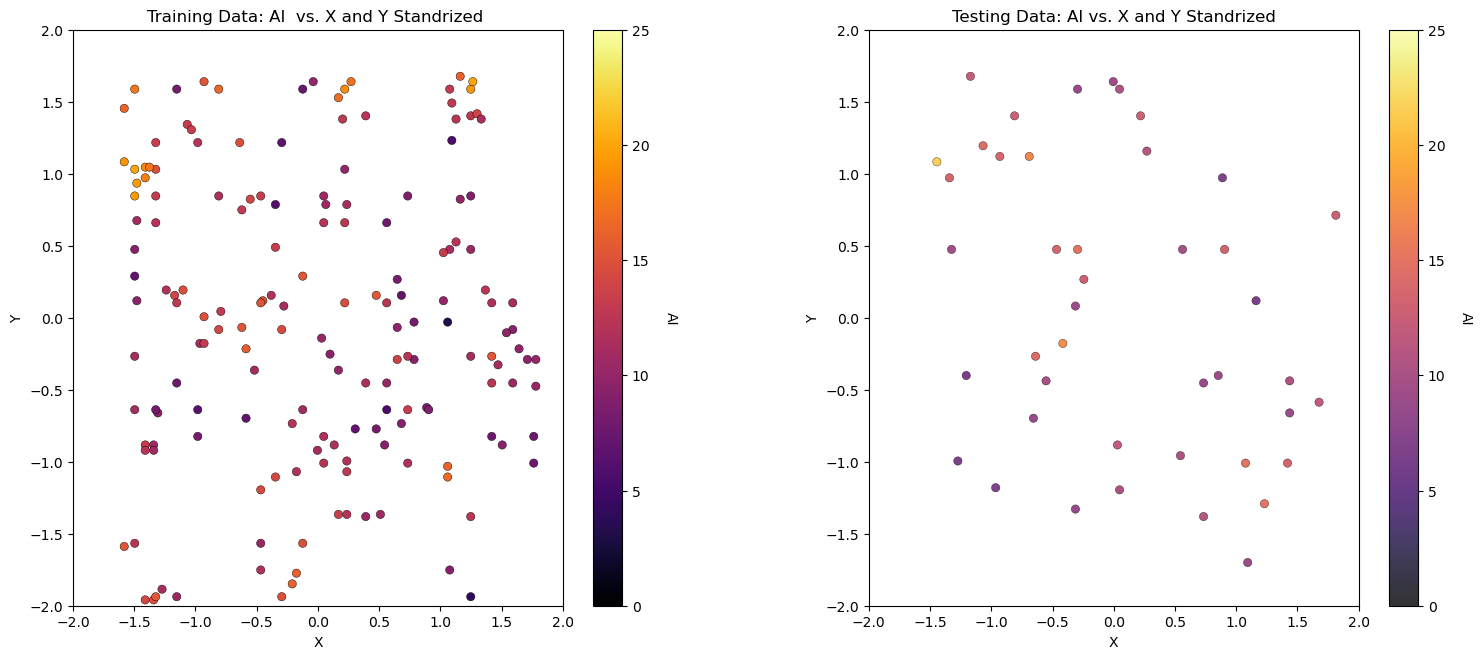

In [58]:
plt.subplot(121)                                          # scatter plot of the training data, 1 row x 2 columns
im = plt.scatter(X_train["sX"],X_train["sY"],s=None, c=y_train["Por"], marker=None, cmap=cmap, norm=None, vmin=por_min, vmax=por_max, alpha=1, linewidths=0.3,edgecolors="black")
plt.title('Training Data: AI  vs. X and Y Standrized '); plt.xlabel('X'); plt.ylabel('Y')
cbar = plt.colorbar(im, orientation = 'vertical'); plt.xlim(X_min,X_max); plt.ylim(Y_min,Y_max)
cbar.set_label("AI", rotation=270, labelpad=20)

plt.subplot(122)                                          # scatter plot of the testing data, 1 row x 2 columns
im = plt.scatter(X_test["sX"],X_test["sY"],s=None, c=y_test["Por"], marker=None, cmap=cmap, norm=None, vmin=por_min, vmax=por_max, alpha=0.8, linewidths=0.3,edgecolors="black")
plt.title('Testing Data: AI vs. X and Y Standrized'); plt.xlabel('X'); plt.ylabel('Y')
cbar = plt.colorbar(im, orientation = 'vertical'); plt.xlim(X_min,X_max); plt.ylim(Y_min,Y_max)
cbar.set_label("AI", rotation=270, labelpad=20)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

Plots look good. We can clearly see that the testing data is a representable data sample of our data set.

# Hyperparameters Tuning

Next, we will use our second and third functions from the start of the workflow to determine the hyperparameter necessary for us to build our K-nearest Neighbor model

# Here will preform the following:

- Compare arithmetic averaging and inverse distance weighing to find which has the lowest testing error (Accuracy).
- Preform k-fold cross validation to see at which K value we will have the smallest error.

These two graphs will allow us to tune our model with the best method and the best K for minimizing the test error.

The testing error is our focus here because thats how we evaluate our model. Constructing the model otherwise (minimizing training error) would result in a model that test's poorly, and thats is not our goal.

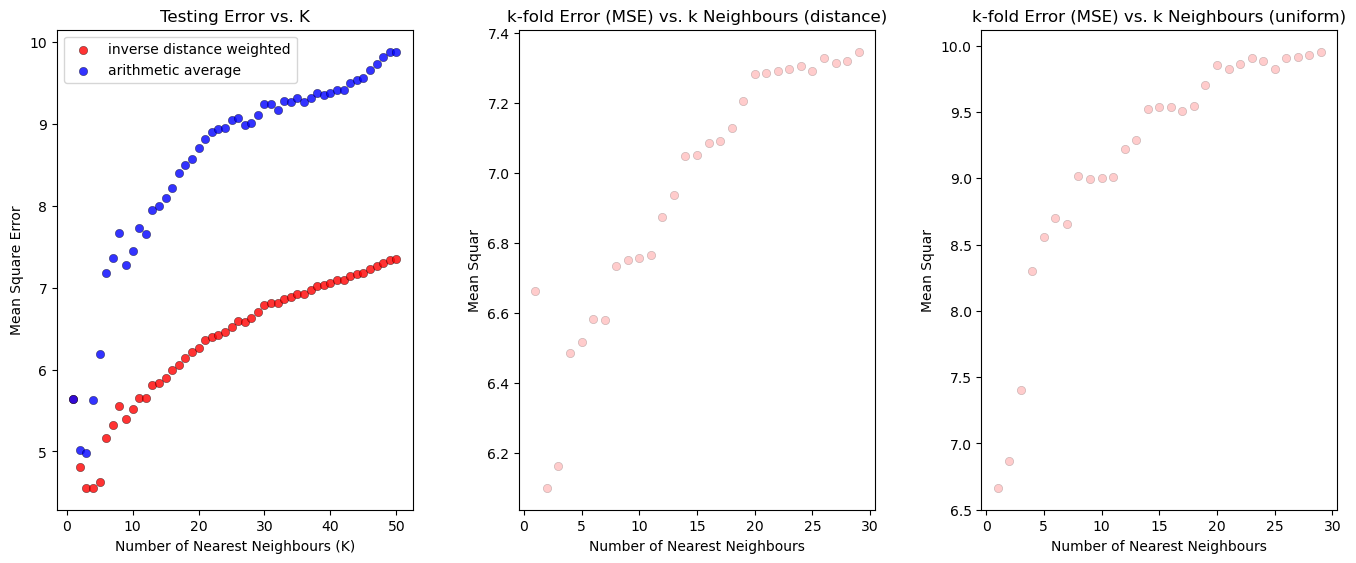

In [59]:
plt.subplot(131)
accuracy_in_testing(X_train,y_train['Por'],X_test,y_test['Por'])

plt.subplot(132)
kFold_plot(df['sX'],df['sY'],df['Por'],'distance')

plt.subplot(133)
kFold_plot(df['sX'],df['sY'],df['Por'],'uniform')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1, wspace=0.3, hspace=0.2)
plt.show()

From our first plot (Left), we can quickly notice that arithmetic averaging has a higher testing error compared to inverse distance weighing. This makes us easier for us to pick which parameter to use, as our goal is to minimize testing error, and inverse distance weighing is the winner!

From the second plot (Middle), we can see the testing error at each number of K neighbors. A very clear minimum at *k* = 2 suggest that this is the optimal K value to use for our model.

With our hyperparameters tuned and ready, we can now Build Our Model. We will show both the training and testing model plots.

/Users/dbc/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/dbc/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


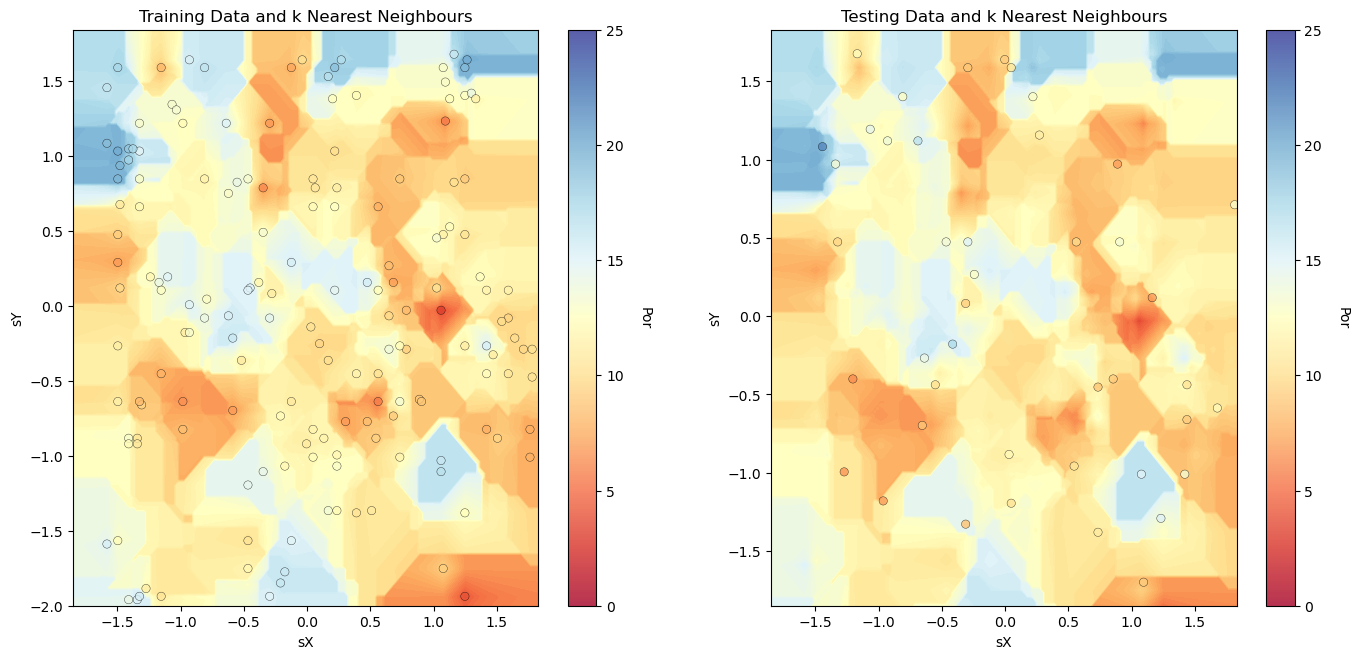

In [60]:
neigh = KNeighborsRegressor(weights = 'distance', n_neighbors=2, p = 1) # instantiate the prediction model
neigh_fit = neigh.fit(X_train,y_train['Por'])              # train the model with the training data

plt.subplot(121)
visualize_model(neigh_fit,X_train["sX"],-1.85,1.85,X_train["sY"],-2,1.85,y_train["Por"],por_min,por_max,'Training Data and k Nearest Neighbours')

plt.subplot(122)
visualize_model(neigh_fit,X_test["sX"],-1.85,1.85,X_test["sY"],-1.85,1.85,y_test["Por"],por_min,por_max,'Testing Data and k Nearest Neighbours')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

The model looks good. We can see the heterogeneities across our model reservoir with patches of high and low AI.

We will move with the workflow to use our Third function to cross validate our model.

Here we will be able to see how our model preformed both in testing and in training.

/Users/dbc/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/dbc/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/dbc/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/dbc/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


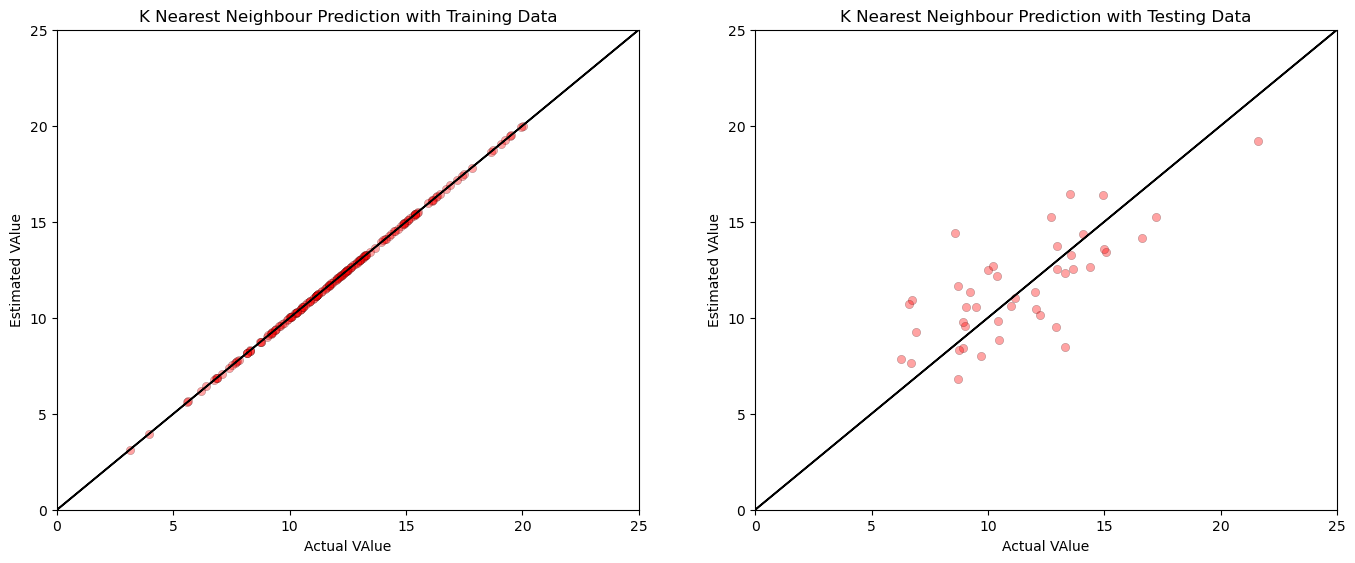

Mean Squared Error in Training =  0.0 , Variance Explained = 1.0
Mean Squared Error in Testing =  4.81 , Variance Explained = 0.53


In [61]:
plt.subplot(121)
check_model(neigh_fit,X_train["sX"],X_train["sY"],y_train["Por"],'K Nearest Neighbour Prediction with Training Data',por_min,por_max)
MSE1,Var1 = check_model(neigh_fit,X_train["sX"],X_train["sY"],y_train["Por"],'K Nearest Neighbour Prediction with Training Data',por_min,por_max)

plt.subplot(122)
check_model(neigh_fit,X_test["sX"],X_test["sY"],y_test["Por"],'K Nearest Neighbour Prediction with Testing Data',por_min,por_max)
MSE2,Var2 =check_model(neigh_fit,X_test["sX"],X_test["sY"],y_test["Por"],'K Nearest Neighbour Prediction with Testing Data',por_min,por_max)


plt.subplots_adjust(left=0.0, bottom=0, right=2, top=1, wspace=.2, hspace=0.2)
plt.show()

print('Mean Squared Error in Training = ', round(MSE1,2),', Variance Explained =', round(Var1,2))
print('Mean Squared Error in Testing = ', round(MSE2,2),', Variance Explained =', round(Var2,2))

Here we can see that the training data is clearly matching very well. Usually, this is an indication of overfit since training is fitting better than testing data. However, remember that in a previous step we determined that inverse distance weighing preforms better in testing than arithmetic mean, despite the apparent over fit observed here. We will keep these hyper parameters as they better serve our purpose.

Finally, Lets now get the the AI values of our new location that we established at the start of this workflow

In [62]:
xx = GSLIB.affine(X_RanLocation,tmean = 1.0,tstdev = 1.0)  
yy= GSLIB.affine(Y_RanLocation,tmean = 1.0,tstdev = 1.0)  
Porosity_Predicted_space = neigh_fit.predict(np.c_[xx, yy])

/Users/dbc/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


# Comparing The Two Porosity Estimations

For our final step, we will now compare the two Porosity estimations that we previously found using the two approaches and find out if the predicter feature selection matters in determining porosity.

First, lets split the X and Y coordinates of our random location points

In [63]:
Differanc_end=Porosity_Predicted_Petro-Porosity_Predicted_space

Now Lets examine the difference on a histogram to see what it looks like

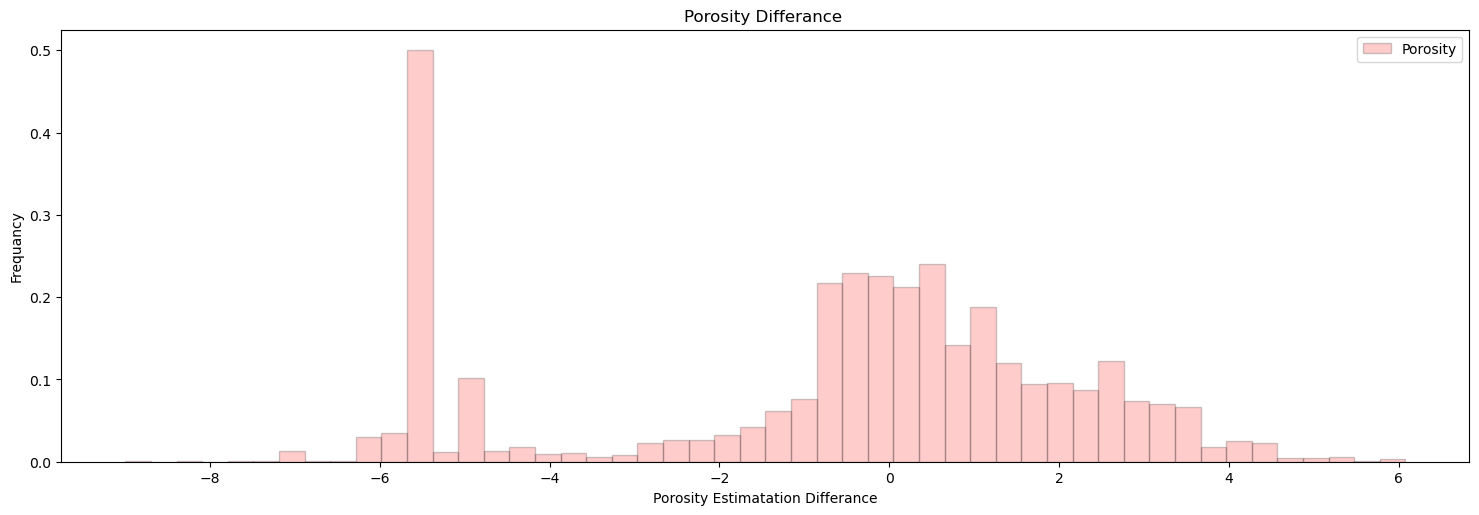

In [64]:
plt.subplot(111)                                                # histogram of training error
plt.hist(Differanc_end, alpha = 0.2, color = 'red', density = True, edgecolor = 'black', bins=50, label = "Porosity")
plt.title('Porosity Differance '); plt.xlabel('Porosity Estimatation Differance'); plt.ylabel('Frequancy')
plt.legend()
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=0.9, wspace=0.3, hspace=0.2)
plt.show()

The way we calculated the difference is that we subtracted the porosity predicted from the petrophysical (PorPetro) properties from the porosity predicted from the spatial properties(PorSpace).

The difference shows that in many cases PorPetro estimation is higher than PorSpace estimation, with an outlier values that have the opposite effect (PorPetrohat<PorSpace) that peaks in a very narrow range.

The main conclusion that we can gather from this fining is that there is a significant difference between using spatial and petrophysical predictor features when using k-nearest neighbor. This conclusion answers the question we posed at the start of the work flow! k-nearest neighbor is sensitive to the type of predictor feature ( spatial vs petrophysical ), with petrophysical predictors yielding larger estimate.

# Notes on the Porosity Differance Histogram

The outlier values indicate that there is a specific area where the two models are predicting very different estimates of porosity. This can be the result of data-gap in one or both of the models,which made the two models predict varying results.

Additionally, petrophysical properties are inherently more correlated to porosity, which can affect the porosity estimation. This was not expected during investigation.